In [1]:
import os
import numpy as np
import scipy.io
from sklearn.preprocessing import StandardScaler

# Define the path to the HIFD dataset
base_path = 'HR_IMU_falldetection_dataset'  # Replace with your actual path

# Initialize lists to store features and labels
X = []
y = []

# Function to extract features from .mat files
def extract_features(mat_data):
    # Extract accelerometer data from ax, ay, az columns
    ax = mat_data['ax']
    ay = mat_data['ay']
    az = mat_data['az']
    acc = np.hstack((ax, ay, az))  # Combine into 3D accelerometer data
    
    # Extract heart rate data - using 'heart' instead of 'hr'
    heart_rate = mat_data['heart'].reshape(-1, 1)  # Reshape to ensure 2D
    
    # Combine all features into a single array
    features = np.hstack((acc, heart_rate))  # Combine into 4D feature vector
    return features

# Print the base path to verify it exists
print(f"Looking for dataset in: {os.path.abspath(base_path)}")
if not os.path.exists(base_path):
    print(f"WARNING: Dataset path '{base_path}' does not exist!")

# Iterate through each subject's folder
for subject_folder in os.listdir(base_path) if os.path.exists(base_path) else []:
    subject_path = os.path.join(base_path, subject_folder)
    if not os.path.isdir(subject_path):
        continue

    # Iterate through 'Fall' and 'Non-Fall' subfolders
    for activity_type in ['Fall', 'Non-Fall']:
        activity_path = os.path.join(subject_path, activity_type)
        if not os.path.exists(activity_path):
            continue

        # Assign label: 1 for 'Fall', 0 for 'Non-Fall'
        label = 1 if activity_type == 'Fall' else 0
        print(f"Processing {activity_type} data from {subject_folder}")

        # Process each .mat file in the activity folder
        for file in os.listdir(activity_path):
            if file.endswith('.mat'):
                file_path = os.path.join(activity_path, file)
                try:
                    mat_data = scipy.io.loadmat(file_path)
                    features = extract_features(mat_data)
                    X.append(features)
                    y.append(np.full(features.shape[0], label))
                    print(f"Successfully processed {file}")
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

# Combine all features and labels (with error handling for empty lists)
if len(X) > 0:
    X = np.vstack(X)
    y = np.concatenate(y)
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f"Processed data: {X.shape[0]} samples, {X.shape[1]} features")
else:
    print("No data was processed. Check your dataset path and structure.")
    X = np.array([])
    y = np.array([])
    X_scaled = np.array([])


Looking for dataset in: /Users/akshaykumar/Documents/Projects/SmartWatch/HR_IMU_falldetection_dataset
Processing Fall data from subject_12
Successfully processed fall6.mat
Successfully processed fall5.mat
Successfully processed fall1.mat
Successfully processed fall2.mat
Successfully processed fall3.mat
Processing Non-Fall data from subject_12
Successfully processed cloth.mat
Successfully processed bed.mat
Successfully processed shoe.mat
Successfully processed teeth.mat
Successfully processed zip.mat
Successfully processed stair.mat
Successfully processed hair.mat
Successfully processed clap.mat
Successfully processed wash.mat
Successfully processed write.mat
Successfully processed walk.mat
Successfully processed chair.mat
Processing Fall data from subject_15
Successfully processed fall6.mat
Successfully processed fall4.mat
Successfully processed fall5.mat
Successfully processed fall1.mat
Successfully processed fall2.mat
Successfully processed fall3.mat
Processing Non-Fall data from sub

In [2]:
def create_windows(X, y, window_size=100, stride=50):
    X_windows, y_labels = [], []
    if len(X) == 0 or len(y) == 0:
        print("No data available for windowing. Ensure data processing was successful.")
        return np.array([]), np.array([])
    
    for i in range(0, len(X) - window_size, stride):
        window = X[i:i + window_size]
        label = np.bincount(y[i:i + window_size]).argmax()  # Majority label
        X_windows.append(window)
        y_labels.append(label)
    return np.array(X_windows), np.array(y_labels)

# Only create windows if we have data
if 'X_scaled' in locals() and len(X_scaled) > 0:
    X_seq, y_seq = create_windows(X_scaled, y, window_size=100, stride=50)
    print(f"Created {len(X_seq)} windows with shape {X_seq.shape}")
else:
    print("Skipping window creation as no scaled data is available")
    X_seq, y_seq = np.array([]), np.array([])


Created 7626 windows with shape (7626, 100, 4)


In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


In [4]:
import ssl
import urllib.request

ssl._create_default_https_context = ssl._create_unverified_context


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(100, X_seq.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.4),
    
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/Users/akshaykumar/Documents/Projects/SmartWatch/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,490 (310.51 KB)

 Trainable params: 79,362 (310.01 KB)

 Non-trainable params: 128 (512.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    validation_split=0.1,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    shuffle=True
)


Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7793 - loss: 0.4749 - val_accuracy: 0.7574 - val_loss: 0.5040
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8120 - loss: 0.3571 - val_accuracy: 0.8574 - val_loss: 0.2832
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8444 - loss: 0.3030 - val_accuracy: 0.8574 - val_loss: 0.2818
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8385 - loss: 0.2992 - val_accuracy: 0.8639 - val_loss: 0.2818
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8425 - loss: 0.2797 - val_accuracy: 0.8721 - val_loss: 0.2522
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8384 - loss: 0.2989 - val_accuracy: 0.8492 - val_loss: 0.2720
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8516 - loss: 0.2781 - val_accuracy: 0.8672 - val_loss: 0.2566
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8602 - loss: 0.2783 - val_accuracy: 0.8721 - v

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8928 - loss: 0.2067
Test Accuracy: 0.8932
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

    Non-Fall       0.97      0.89      0.93      1168
        Fall       0.71      0.91      0.80       358

    accuracy                           0.89      1526
   macro avg       0.84      0.90      0.86      1526
weighted avg       0.91      0.89      0.90      1526



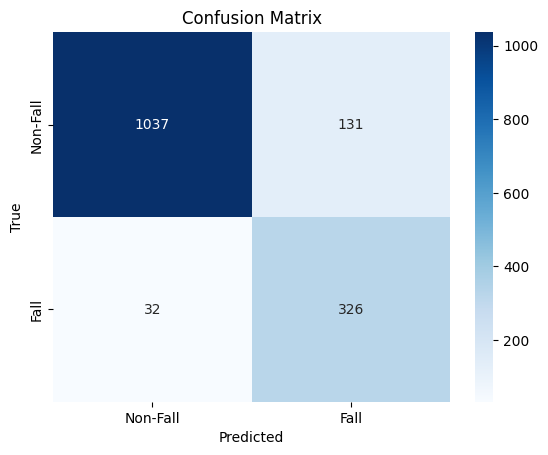

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")

y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred, target_names=["Non-Fall", "Fall"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fall", "Fall"], yticklabels=["Non-Fall", "Fall"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [10]:
# Save the entire model to a file (HDF5 format)
model.save('fall_detection_model.h5')
